In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import plotly_express as px
from lib.helper import Db, lmplot

In [2]:
import seaborn as sns

In [3]:
sns.set()

# Import Tables

In [4]:
base_path = ''
db_file = f'{base_path}db/ussc.db'
db = Db(db_file)
OHCO = ['vol_num','case_num','position']

In [5]:
# db.list_tables_in_db()

In [6]:
vspace = 'NMF' # LDA or NMF

In [7]:
db.import_table('CASE', OHCO[:2])
db.import_table(f'{vspace}_THETA', OHCO)
db.import_table(f'{vspace}_TOPICS', 'topic_id')

In [8]:
THETA = getattr(db, f'{vspace}_THETA')
TOPICS = getattr(db, f'{vspace}_TOPICS')

In [9]:
n_topics = TOPICS.shape[0]

In [10]:
n_topics

40

# Sort Topics by Doc Weight

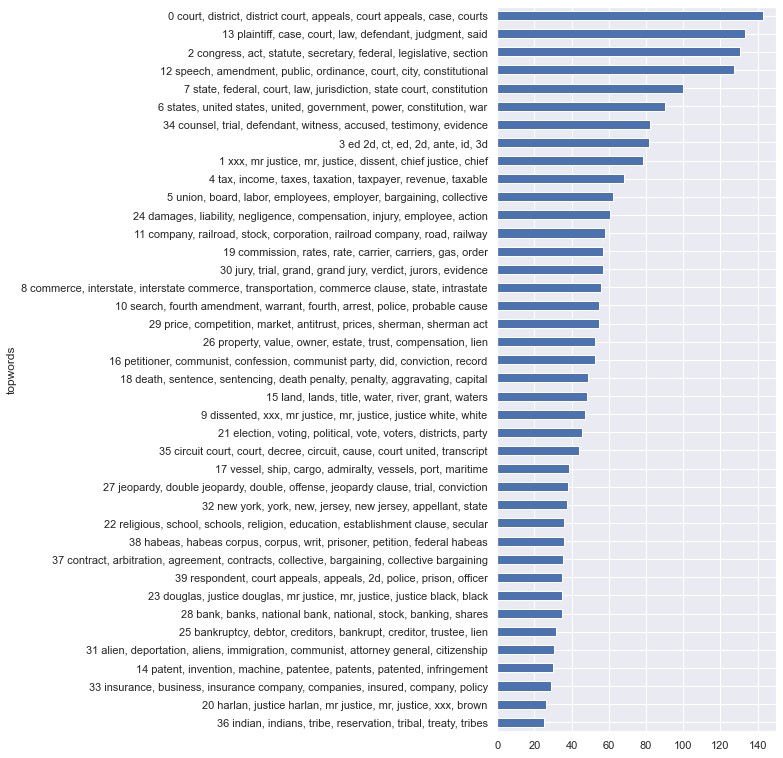

In [12]:
TOPICS.sort_values('doc_weight_sum', ascending=True)\
    .plot.barh(y='doc_weight_sum', x='topwords', figsize=(5, n_topics/3), legend=False);

# Topic Pair Distances

In [13]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [14]:
SIMS = pdist(normalize(THETA.T), metric='cosine')

# Draw HAC Tree

In [18]:
def plot_tree(tree, labels):
    global n_topics
    plt.figure()
    fig, axes = plt.subplots(figsize=(5, n_topics / 3))
    dendrogram = sch.dendrogram(tree, labels=labels, orientation="left")
    plt.tick_params(axis='both', which='major', labelsize=14)

In [19]:
TREE = sch.linkage(SIMS, method='ward')

<Figure size 432x288 with 0 Axes>

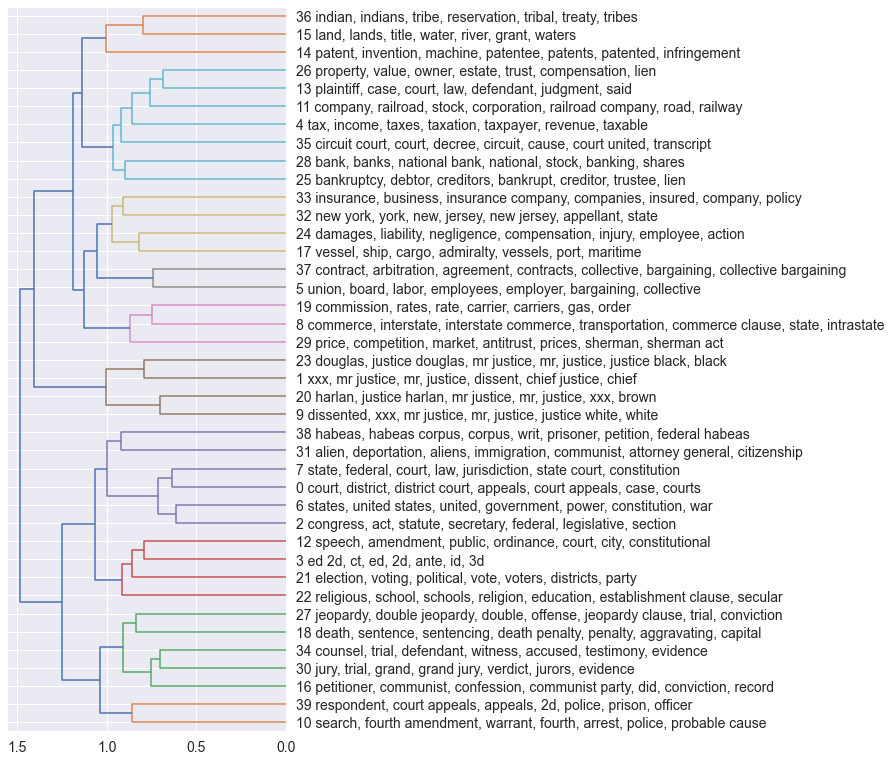

In [20]:
plot_tree(TREE, TOPICS.topwords.to_list());

# Square Matrix of Distances

In [21]:
TDIST = pd.DataFrame(squareform(SIMS)).stack().to_frame('dist')
TDIST.index.names = ['topic_a','topic_b']

In [22]:
TDIST.sort_values('dist', ascending=False).head(10)

dist
topic_a topic_b          
22      9        0.999866
9       22       0.999866
36      9        0.999673
9       36       0.999673
14      18       0.999639
18      14       0.999639
31      9        0.999590
9       31       0.999590
        39       0.999579
39      9        0.999579

# Get Top Topics for Each Opinion  $X$

In [23]:
Z = ((TOPICS.doc_weight_sum - TOPICS.doc_weight_sum.mean()) / TOPICS.doc_weight_sum.std()).to_frame('z')

<AxesSubplot:>

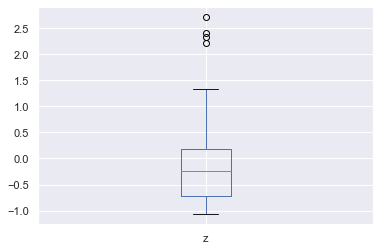

In [24]:
Z.plot.box()

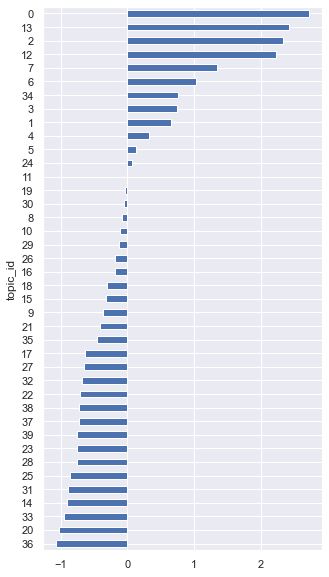

In [25]:
Z.sort_values('z').plot.barh(figsize=(5,10), legend=False);

## Remove Outlier Topics

In [78]:
z_thresh = 2

In [79]:
idx = [str(i) for i in Z[Z.z.abs() <= z_thresh].index]

In [80]:
X = THETA[idx].idxmax(1).to_frame('max_topic_id').sort_index()
X.max_topic_id = X.max_topic_id.astype('int')

In [81]:
X['topwords'] = X.max_topic_id.map(TOPICS.topwords)

In [82]:
X.head(10)

max_topic_id  \
vol_num case_num position                 
3       171      dissent             35   
                 opinion              4   
        321      dissent             35   
                 opinion             35   
        386      dissent              7   
                 opinion              7   
6       358      dissent              6   
                 opinion              6   
7       300      dissent             25   
                 opinion             25   

                                                                    topwords  
vol_num case_num position                                                     
3       171      dissent   35 circuit court, court, decree, circuit, caus...  
                 opinion   4 tax, income, taxes, taxation, taxpayer, reve...  
        321      dissent   35 circuit court, court, decree, circuit, caus...  
                 opinion   35 circuit court, court, decree, circuit, caus...  
        386      dissent   7 state, federal, court, law, jurisdiction, st...  
                 opinion   7 state, federal, court, law, jurisdiction, st...  
6       358      dissent   6 states, united states, united, government, p...  
                 opinion   6 states, united states, united, government, p...  
7       300      dissent   25 bankruptcy, debtor, creditors, bankrupt, cr...  
                 opinion   25 bankruptcy, debtor, creditors, bankrupt, cr...

# Unstack $X$ &rarr; $X1$

In [83]:
X1 = X.max_topic_id.unstack().sort_index()
X1['test'] = X1.dissent != X1.opinion
X1.test = X1.test.astype('int')
X1 = X1.rename(columns={'dissent':'dissent_topic', 'opinion':'opinion_topic'})

In [84]:
X1.head()

position          dissent_topic  opinion_topic  test
vol_num case_num                                    
3       171                  35              4     1
        321                  35             35     0
        386                   7              7     0
6       358                   6              6     0
7       300                  25             25     0

# Add Top Topic Distances

In [85]:
X1['topic_dist'] = X1.apply(lambda x: TDIST.loc[x.dissent_topic, x.opinion_topic], 1)

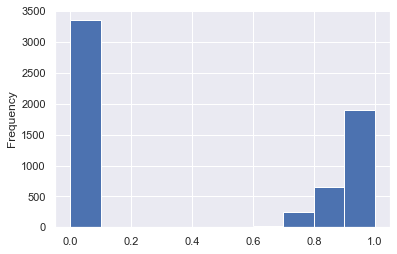

In [86]:
X1.topic_dist.sort_values().plot.hist();

## Add Year to $X1$

In [87]:
try:
    X1 = X1.join(db.CASE.year)
except:
    pass

# Mean Topic Distance per Year $X2$

In [88]:
X1.head()

dissent_topic  opinion_topic  test  topic_dist  year
vol_num case_num                                                      
3       171                  35              4     1    0.975798  1796
        321                  35             35     0    0.000000  1796
        386                   7              7     0    0.000000  1798
6       358                   6              6     0    0.000000  1805
7       300                  25             25     0    0.000000  1806

In [89]:
X2 = X1.groupby('year').topic_dist.mean().to_frame('mean_dist')

In [90]:
X2.head()

,mean_dist
year,
1789,0.000000
1796,0.487899
1798,0.000000
1805,0.000000
1806,0.000000


# Consider only 20th Century $X3$

In [91]:
X3 = X2.loc[X2.index >= 1900]

In [92]:
X3.head()

,mean_dist
year,
1900,0.824147
1901,0.697817
1902,0.659754
1903,0.756642
1904,0.718345


# Plot of $X3$

In [93]:
P = lmplot(X3.reset_index()).set_x('year').set_y('mean_dist')

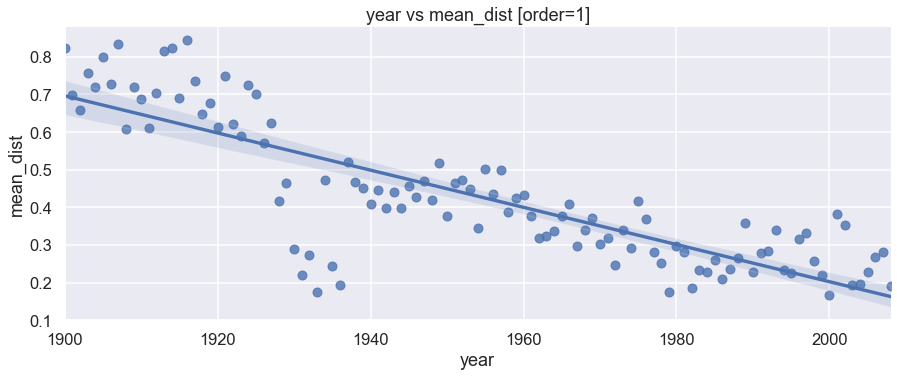

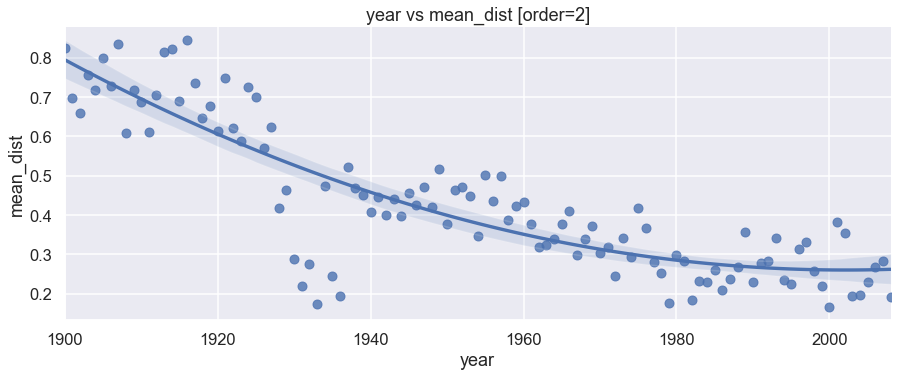

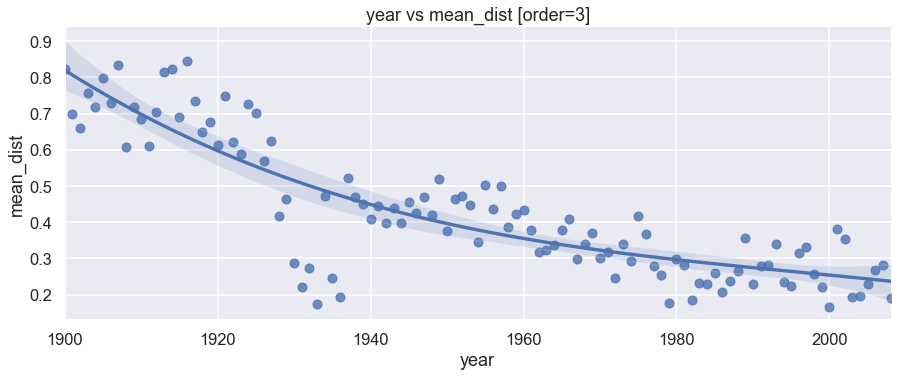

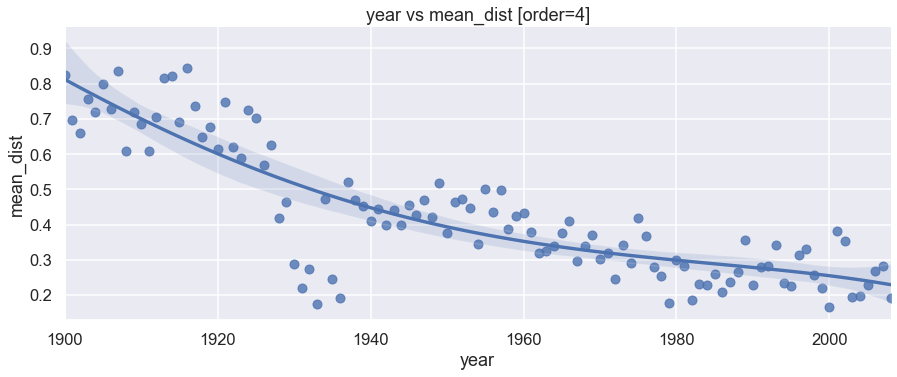

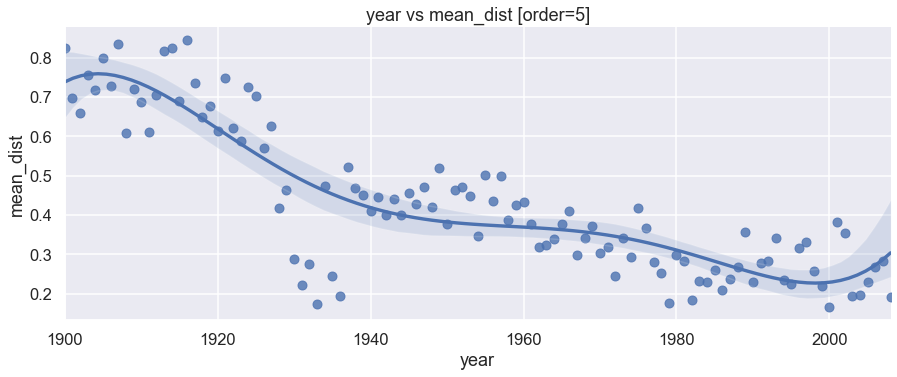

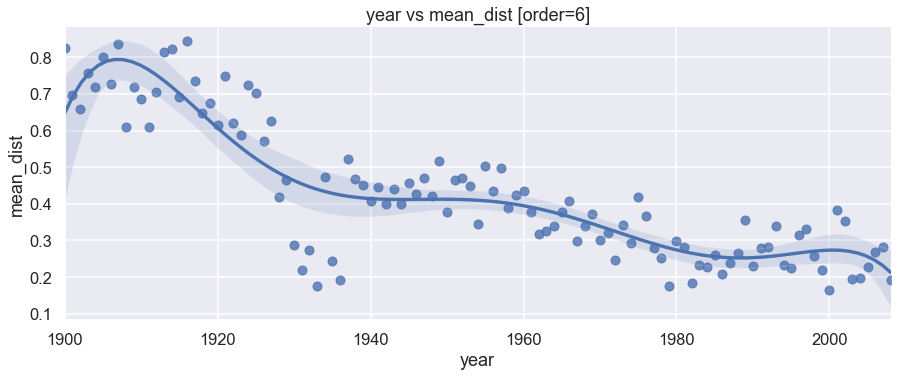

In [94]:
for order in range(1,7):
    P.set_order(order)
    P.plot()

# Predict

In [95]:
x = [1900 + i for i in range(X3.shape[0])]
y = X3.mean_dist.tolist()
domain = [X3.index[0], X3.index[-1]]
max_order = 6

In [96]:
P = pd.DataFrame([np.polynomial.Polynomial.fit(x, y, i).convert() for i in range(max_order+1)]).fillna(0)

In [97]:
P

,0,1,2,3,4,5,6
0,4.295686e-01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.007948e+01,-4.938545e-03,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2.060796e+02,-2.056048e-01,0.000051,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,3.217100e+03,-4.829900e+00,0.002418,-4.037781e-07,0.000000e+00,0.000000e+00,0.000000e+00
4,-5.838604e+04,1.213189e+02,-0.094442,3.264677e-05,-4.228576e-09,0.000000e+00,0.000000e+00
5,-3.986565e+07,1.020175e+05,-104.416439,5.343082e-02,-1.366922e-05,1.398668e-09,0.000000e+00
6,-3.410274e+09,1.045493e+07,-13353.958781,9.096319e+00,-3.485074e-03,7.120742e-07,-6.061715e-11


In [98]:
def predict(x, order=1):
    global P
    y = (P.loc[order] * pd.Series([x**z for z in range(order+1)])).sum()
    return y

In [99]:
xt = 2021

In [100]:
predict(xt, 3)

0.20511302596059977

# Case Topics over Time $X4$

In [101]:
X4 = db.CASE.join(X1[['dissent_topic','opinion_topic','topic_dist']])\
    [['year', 'dissent_topic', 'opinion_topic', 'topic_dist']]\
    .reset_index().drop_duplicates()
X4 = X4.reset_index(drop=True).set_index(['vol_num', 'case_num', 'year']).sort_index()

In [102]:
X4

dissent_topic  opinion_topic  topic_dist
vol_num case_num year                                          
3       1        1794            NaN            NaN         NaN
        6        1794            NaN            NaN         NaN
        17       1795            NaN            NaN         NaN
        121      1795            NaN            NaN         NaN
        171      1796           35.0            4.0    0.975798
...                              ...            ...         ...
554     407      2008           18.0           18.0    0.000000
        471      2008           24.0           24.0    0.000000
        527      2008            3.0           19.0    0.969106
        570      2008            3.0            3.0    0.000000
        724      2008            NaN            NaN         NaN

[22102 rows x 3 columns]

## Dissenting and Opinion Topic Heatmaps $X5$ $X6$

In [103]:
X5 = X4.groupby(['year','dissent_topic']).dissent_topic.count().to_frame().unstack().fillna(0)
X5.columns = X5.columns.droplevel(0)
X5 = X5.astype('int')

In [104]:
X6 = X4.groupby(['year','opinion_topic']).dissent_topic.count().to_frame().unstack().fillna(0)
X6.columns = X6.columns.droplevel(0)
X6 = X6.astype('int')

In [105]:
# X5.tail(30).T.style.background_gradient(cmap='YlGnBu')

In [106]:
# X6.tail(30).T.style.background_gradient(cmap='YlGnBu')

## Dot Prodict of $X5$ abd $X6$ $= X7$

In [107]:
X7 = X5.T.dot(X6)

In [108]:
# X7.style.background_gradient(cmap='YlGnBu', axis=1)

## Bar Charts per Topic $X8$

In [109]:
opinion = X6.stack().to_frame('n')
opinion['type'] = 'opinion'
dissent = X5.stack().to_frame('n')
dissent['type'] = 'dissent'
X8 = pd.concat([opinion, dissent]).reset_index()
X8.columns = ['year', 'topic_id', 'n', 'type']
X8.topic_id = X8.topic_id.astype('int')

In [110]:
X8

,year,topic_id,n,type
0,1789,1,0,opinion
1,1789,3,0,opinion
2,1789,4,0,opinion
3,1789,5,0,opinion
4,1789,6,0,opinion
...,...,...,...,...
13059,2008,35,0,dissent
13060,2008,36,0,dissent
13061,2008,37,1,dissent
13062,2008,38,1,dissent


In [111]:
X9 = X8.groupby(['year', 'topic_id']).n.sum().to_frame('n').unstack()

In [112]:
# X9

In [113]:
X10 = (X9.T / X9.T.sum()).T
X10.columns = X10.columns.droplevel(0)
X10 = X10.stack().to_frame('p').reset_index()

In [114]:
X10.head()

,year,topic_id,p
0,1789,1,0.0
1,1789,3,0.0
2,1789,4,0.0
3,1789,5,0.0
4,1789,6,0.0


In [115]:
def plot_topic_over_years(tn, start_year=1900):
    global X10
    title = 'Topic ' + TOPICS.loc[tn].topwords    
    i = px.bar(X10[(X10.year >= start_year) & (X10.topic_id == tn)], x='year', y='p', title=title)
    i.show()

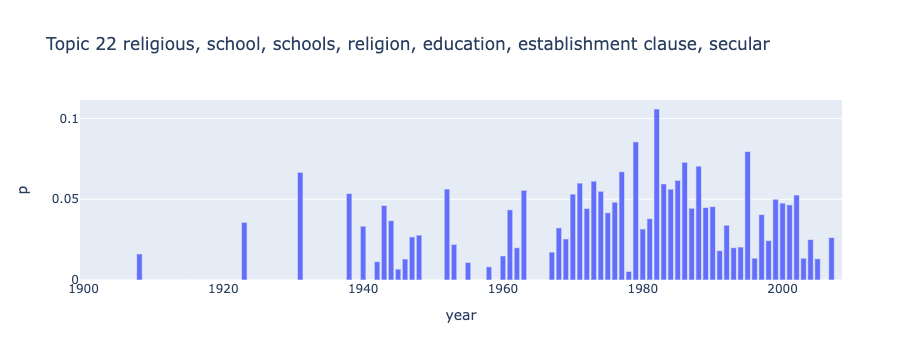

In [116]:
plot_topic_over_years(22)

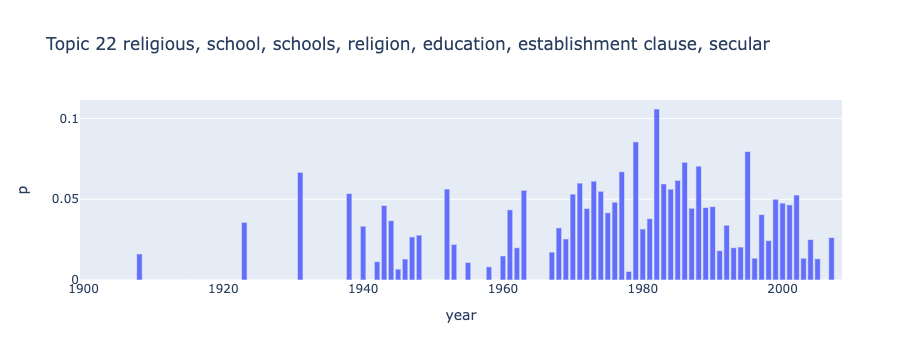

In [117]:
plot_topic_over_years(22)

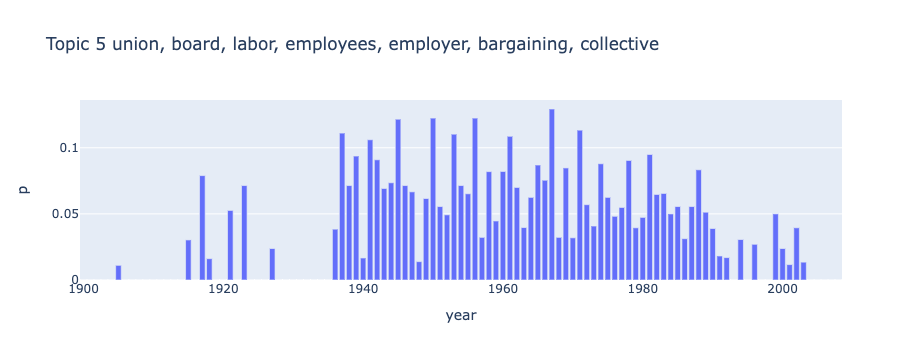

In [118]:
plot_topic_over_years(5)

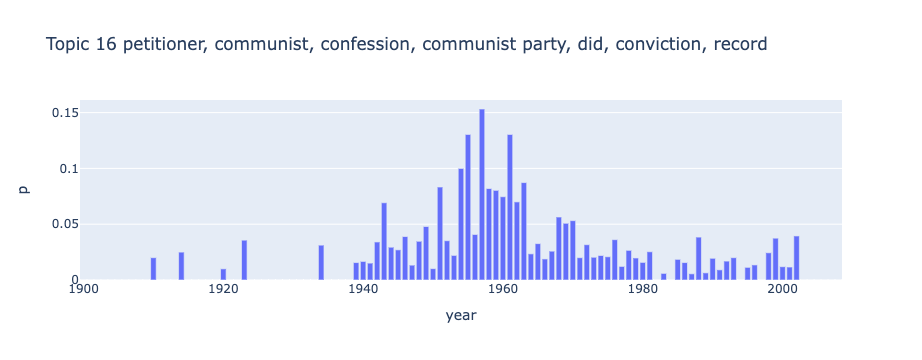

In [119]:
plot_topic_over_years(16)

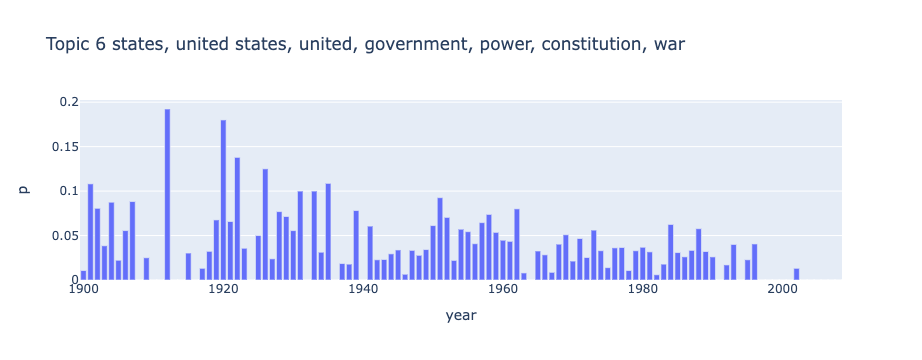

In [120]:
plot_topic_over_years(6)

## Dispersion Plots

In [121]:
X8.head()

,year,topic_id,n,type
0,1789,1,0,opinion
1,1789,3,0,opinion
2,1789,4,0,opinion
3,1789,5,0,opinion
4,1789,6,0,opinion


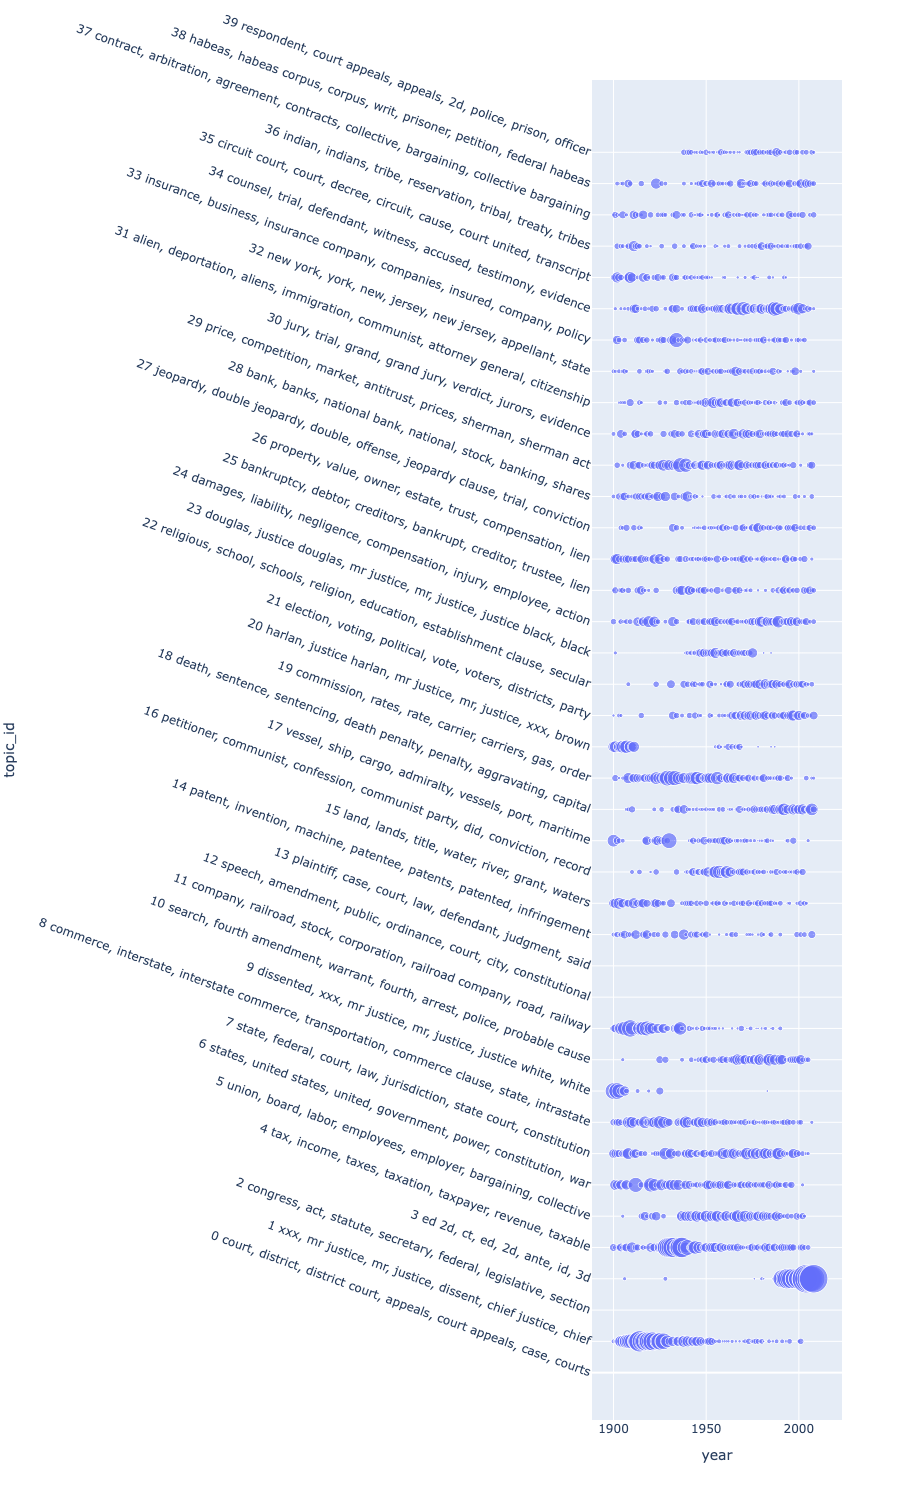

In [122]:
fig = px.scatter(X10[X10.year >= 1900], 'year', 'topic_id', size='p', height=1500)
fig.update_yaxes(tickmode='array', tickvals=TOPICS.index, ticktext = TOPICS.topwords.to_list(), tickangle=20)
fig.show()

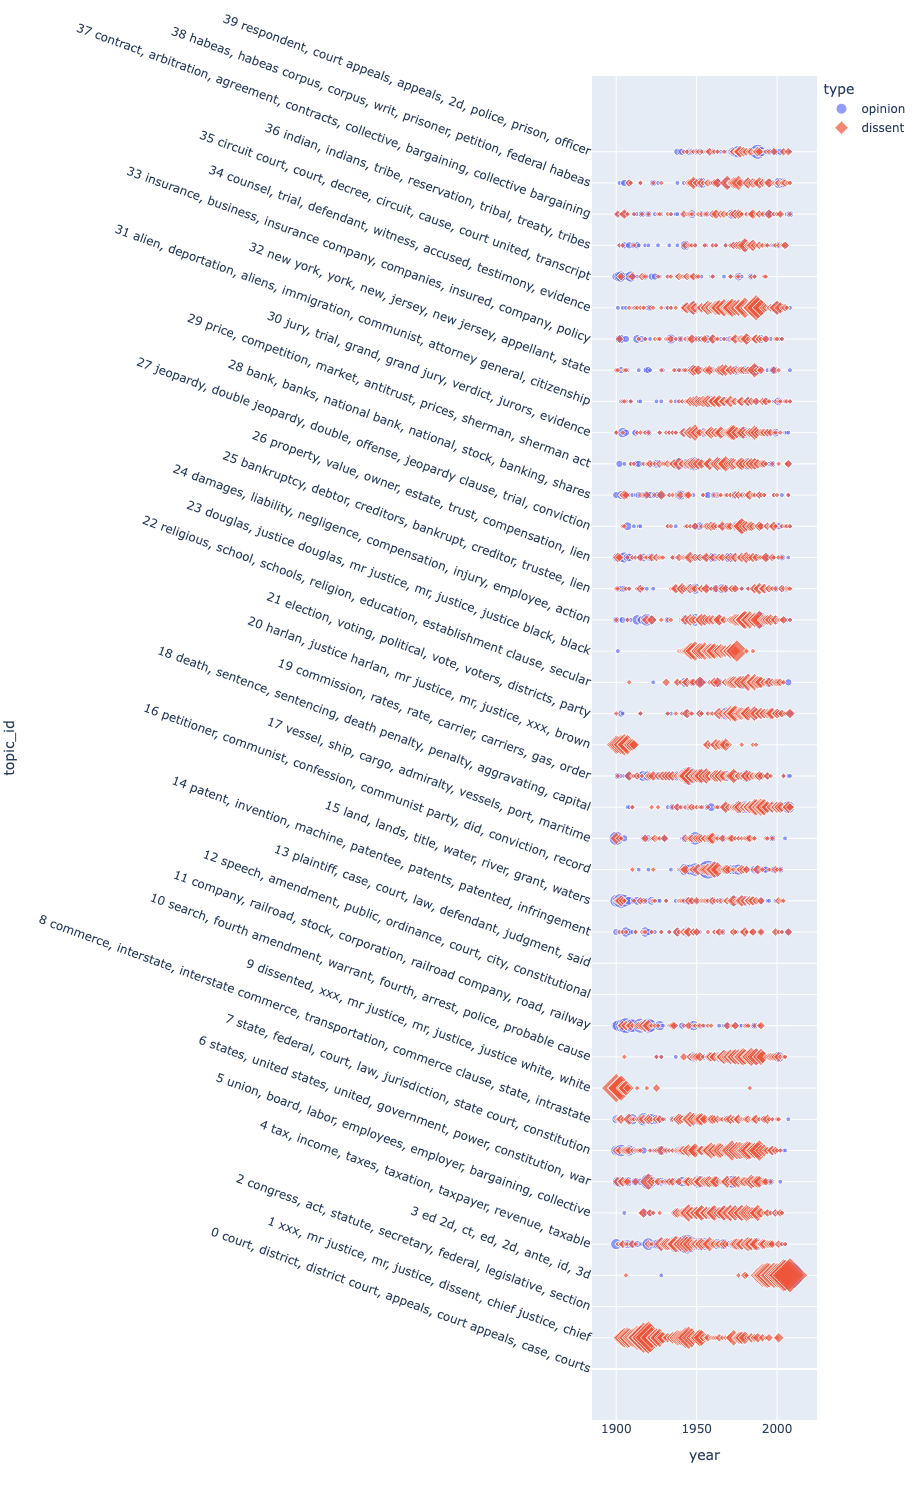

In [123]:
fig = px.scatter(X8[X8.year >= 1900], 'year', 'topic_id', color='type', symbol='type', size='n', height=1500)
fig.update_yaxes(tickmode='array', tickvals=TOPICS.index, ticktext = TOPICS.topwords.to_list(), tickangle=20)
fig.show()